## The Battle of the Neighborhoods

This notebook will be used to solve the final assignment of the Coursera "Applied Data Science Capstone" course, __Battle of the Neighborhoods__. In this assignment I have to apply what I learn got through the "IBM Data Science Professional Certificate" and purpose a problem from my choice that I would like to solve using Foursquare data.

*Paulo Fernandes*

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Moving to a different city is a decision that a lot of people must deal with throughout their lives especially for young people looking for new and better jobs or going to college. Trying to decide about something new and unknown is always stressful but the best decisions usually have strong support with data. I'm going to use this task to try to answer a problem that can be useful for these people including myself:  __"If I get a job offer in a different city, what would be the best places to considerer moving in?"__
Probably there will be more than one place that will fulfill our requirements, but in general, this place is going to be as cheap as possible while complaining about our essential demands.  
The city that I will analyze will be Porto, Portugal. It is the second city in Portugal and a place that I'm considering moving in, so I will use this work to get more knowledge about the city and the renting business. The house pricing and rents in Portugal are increasing year over the year especially in Lisbon and Porto due to the concentration of opportunities in these areas.


## Data <a name="data"></a>

To solve this problem, I build two datasets with the help of Google maps location [1] that will help me solve the problem:
- A dataset of 50 rooms and flats to rent in Porto with the information I obtained from a web page of renting business [2];
- A dataset of the subway of Porto's subway stations because I didn't find any on the web and me considerer the distance from my place to a subway station an important measure; 

Both these datasets will be added to the GitHub repository. To complete my work, I'm going to use the Foursquare data to get venues around the places that I select to try to classify them. The goal is to try to get the best deals from my perspective. Having a gym close by is a must be in my opinion, because after a day of work I love to go there and have my workout hour.
As I have said already, the answer to this problem will be biased to my demands. But that doesn't mean that the methodology that I'm going to try to develop cannot be used by other people with similar goals but different tasks. Maybe having a gym and a subway station close by isn't that important for you because you rather workout outside and having your car. So, you probably would considerer more important a place with a garage or parking lot and close to a park. Features I will take into consideration:
- Price;
- Number of venues close by;
- Subway station close by;
- Gym close by:

#### Let's import the libraries.

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


#### Now, let's check and plot on a folium map both my built-in datasets locations:

In [4]:
address = 'Porto, Portugal'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ' + address +' are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Porto, Portugal are 41.1494512, -8.6107884.


#### The subway stations locations:

In [5]:
#importing and clean the dataset:
dfSubway = pd.read_excel('SubwayPortoStations.xlsx')
dfSubway = dfSubway.dropna()
dfSubway.reset_index(drop=True, inplace=True)
dfSubway.head()

,Nome,Linha,Latitude,Longitude
0,Aeroporto,E,41.237455,-8.669518
1,Aliados,D,41.148587,-8.610948
2,Alto de Pêga,B,41.365287,-8.745053
3,Araújo,C,41.217939,-8.641021
4,Árvore,B,41.340756,-8.725598


In [6]:
dfSubway.shape

(82, 4)

In [7]:
#plot a follium map with the subway station of metro of Porto
map_porto_stations = folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lng, name in zip(dfSubway['Latitude'], dfSubway['Longitude'], dfSubway['Nome']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_porto_stations)   
map_porto_stations

#### The renting places dataset:

In [8]:
dfRent = pd.read_excel('rentings.xlsx')
dfRent.reset_index(drop=True, inplace=True)
dfRent.head()

,Type,Furniture,Bills included,Latitude,Longitude,Price €/month
0,room,yes,yes,41.171966,-8.587178,410
1,room,yes,yes,41.191279,-8.615421,300
2,room,yes,no,41.166586,-8.597017,280
3,room,yes,yes,41.122323,-8.607831,350
4,room,yes,yes,41.152645,-8.621085,380


In [9]:
dfRent.shape

(49, 6)

In [10]:
#plot a follium map of the places to rent in Porto
map_porto_rents = folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lng, price in zip(dfRent['Latitude'], dfRent['Longitude'], dfRent['Price €/month']):
    label = '{}'.format(price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_porto_rents)  
map_porto_rents

#### To close my data section lets use the Foursquare API to get the venues going by 'gym/fitness' around a renting place:

In [11]:
#Foursquare credentials:
CLIENT_ID = 'MKSMC1YKOJXMX1Y44OUGCPE1LL4U0SFUYXTXYLFE0XFLNFYE' # your Foursquare ID
CLIENT_SECRET = 'KOYJSXPEBH0311KFDZV5X43WGOLQQPSHQ5M2AINCC0I0TFNN' # your Foursquare Secret
VERSION = '20202704'

In [12]:
#Lets get the location from the first renting place on the dataset:
latitude=dfRent['Latitude'][0]
longitude=dfRent['Longitude'][0]

#Now lets get the information using the Foursquare location and a radius of 1km
search_query = ['gym', 'fitness']
LIMIT = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

#Create a dataframe with the results
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,5b75c7b0e4c459002c9fe450,Fitness Hut Antas,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1591213247,False,Rua dos Campeões Europeus de Viana,Rua Professor Manuel Baganha,41.164012,-8.583066,"[{'label': 'display', 'lat': 41.164012, 'lng':...",950,4350-009,PT,Porto,Porto,Portugal,[Rua dos Campeões Europeus de Viana (Rua Profe...
1,50763fe7e4b065d50c3d2f57,FADEUP Gym,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1591213247,False,"Rua Dr. Plácido Costa, 91",NaN,41.172421,-8.598321,"[{'label': 'display', 'lat': 41.17242068503088...",935,NaN,PT,NaN,NaN,Portugal,"[Rua Dr. Plácido Costa, 91, Portugal]"
2,56e06bc2cd10ec50acbb9a1f,Elite Fitness studio,"[{'id': '52e81612bcbc57f1066b7a35', 'name': 'C...",v-1591213247,False,NaN,NaN,41.173997,-8.582970,"[{'label': 'display', 'lat': 41.1739973591177,...",418,NaN,PT,NaN,NaN,Portugal,[Portugal]


In [13]:
#Lets get the location from the second renting place on the dataset:
latitude=dfRent['Latitude'][1]
longitude=dfRent['Longitude'][1]

#Now lets get the information using the Foursquare location and a radius of 1km
search_query = ['gym', 'fitness']
LIMIT = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

#Create a dataframe with the results
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


""


As we can see, the first place on the dataset has 3 gym/fitness places within 1km while the seconds has none.

## Methodology <a name="methodology"></a>

In this project, I'm going to detect the best rooms/flats that will comply with my requirements. The place should be less than 1km to a gym and subway station. On top of that, the price and the number of venues will also have an impact in my decision. Because my dataset is relatively small and not diversified enough, the clustering of locations can not be useful but I will apply it anyway and try to see if the number of venues and the closeness to a subway station impact the price of the room/flat.

## Analysis <a name="analysis"></a>

During the Data section, I already did a presentation of my datasets. Let's do some analysis and cleaning on them. I build the subway station datasets in a way that does not require any kind of treatment. We have the name of the station, the metro line and the latitude and longitude values of the places (I let the headers in Portuguese):

In [14]:
dfSubway.head()

,Nome,Linha,Latitude,Longitude
0,Aeroporto,E,41.237455,-8.669518
1,Aliados,D,41.148587,-8.610948
2,Alto de Pêga,B,41.365287,-8.745053
3,Araújo,C,41.217939,-8.641021
4,Árvore,B,41.340756,-8.725598


The other built-in dataset has the places that I selected as renting options: dfRents.

In [15]:
dfRent.head()

,Type,Furniture,Bills included,Latitude,Longitude,Price €/month
0,room,yes,yes,41.171966,-8.587178,410
1,room,yes,yes,41.191279,-8.615421,300
2,room,yes,no,41.166586,-8.597017,280
3,room,yes,yes,41.122323,-8.607831,350
4,room,yes,yes,41.152645,-8.621085,380


dfRents has 3 types of options: 24 room (sharing), 13 studios and  12 t1.

In [16]:
dfRent.groupby('Type').count()

,Furniture,Bills included,Latitude,Longitude,Price €/month
Type,,,,,
room,24,24,24,24,24
studio,13,13,13,13,13
t1,12,12,12,12,12


The 'Bills included' is an important information an d factor on the price of the renting. This usually means that the some extra expenses like energy, internet and water are already included in the price, usually with a responsable consuption politic. For the places that have no bills included I'm going to add a extra 100€ to the price of the renting.  

In [17]:
dfRent.groupby('Bills included').count()

,Type,Furniture,Latitude,Longitude,Price €/month
Bills included,,,,,
no,40,40,40,40,40
yes,9,9,9,9,9


In [18]:
for i in dfRent.index:
    if dfRent['Bills included'][i]=='no':
        dfRent.at[i, 'Price €/month'] = dfRent['Price €/month'][i]+100 

Also, I'm gonna drop the places without furniture, because it means a extra expense that I'm not considering to pay:

In [19]:
indexRents = dfRent[ dfRent['Furniture'] == 'no' ].index
dfRent.drop(indexRents , inplace=True)
dfRent.shape

(37, 6)

Our final dataset consists of 38 places to rent. If we group agian by group we can see that the number of rooms is the same but the options for studio and t1 have being reduced. This was expected dueing to the nature of the business.

In [20]:
dfRent.groupby('Type').count()

,Furniture,Bills included,Latitude,Longitude,Price €/month
Type,,,,,
room,24,24,24,24,24
studio,7,7,7,7,7
t1,6,6,6,6,6


Now I need to create classes for range of prices. 
For rooms the classes will be:
- Low: <300€/month
- Medium: (300-400)€/month
- High: >400€/ month

For studio adn t1, I will use the same 3 classes for the ranges:
- Low: <350€/month
- Medium: (350-450)€/month
- High: >450€/ month

In [21]:
#adding a column with the class price to the dataframe
dfRent['Class price']=""
for i in dfRent.index:
    if dfRent['Type'][i]=='room':
        if dfRent['Price €/month'][i]<300:
            dfRent.at[i, 'Class price'] = 'Low'
        elif dfRent['Price €/month'][i]>400:
            dfRent.at[i, 'Class price'] = 'High'
        else:
            dfRent.at[i, 'Class price'] = 'Medium'
    else:
        if dfRent['Price €/month'][i]<350:
            dfRent.at[i, 'Class price'] = 'Low'
        elif dfRent['Price €/month'][i]>450:
            dfRent.at[i, 'Class price'] = 'High'
        else:
            dfRent.at[i, 'Class price'] = 'Medium'
dfRent

,Type,Furniture,Bills included,Latitude,Longitude,Price €/month,Class price
0,room,yes,yes,41.171966,-8.587178,410,High
1,room,yes,yes,41.191279,-8.615421,300,Medium
2,room,yes,no,41.166586,-8.597017,380,Medium
3,room,yes,yes,41.122323,-8.607831,350,Medium
4,room,yes,yes,41.152645,-8.621085,380,Medium
5,room,yes,no,41.177033,-8.611005,400,Medium
6,room,yes,no,41.171456,-8.594277,400,Medium
7,room,yes,yes,41.121041,-8.606290,200,Low
8,room,yes,no,41.178154,-8.549249,350,Medium
9,room,yes,no,41.184385,-8.608058,350,Medium


Now lets represent the places to renting with diferent class of prices on a follium map. We can see that there are no 'Low' price places closing to the center of the city:

In [22]:
#plot a follium map of the places to rent in Porto
map_porto_rents = folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lng, price in zip(dfRent['Latitude'], dfRent['Longitude'], dfRent['Class price']):
    label = '{}'.format(price)
    label = folium.Popup(label, parse_html=True)
    if price=='Low':
        colorx='blue'
    elif price=='Medium':
        colorx='yellow'
    elif price=='High':
        colorx='red'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colorx,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_porto_rents)  
map_porto_rents

Let's now see if a place has a subway station closer than 1km. To do this, I'm gonna create a new column on the 'dfRents' and using a mathmatical algorithm using the latitude and longitude info from both 'dfRent' and 'dfSubway' datasets.

In [23]:
#function to obtain the distance betwenn 2 points using lat lon coordinates
from math import sin, cos, sqrt, atan2, radians
def distance_latlon(lt1, ln1, lt2, ln2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lt1)
    lon1 = radians(ln1)
    lat2 = radians(lt2)
    lon2 = radians(ln2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [24]:
#adding a column with the class price to the dataframe
dfRent['Subway station <1km']=""
control = False
for i in dfRent.index:
    lt1=dfRent['Latitude'][i]
    ln1=dfRent['Longitude'][i]
    for j in dfSubway.index:
        lt2=dfSubway['Latitude'][j]
        ln2=dfSubway['Longitude'][j]
        distance = distance_latlon(lt1, ln1, lt2, ln2)
        if distance < 0.5:
            dfRent['Subway station <1km'][i]=True
            break
        else:
            dfRent['Subway station <1km'][i]=False
dfRent

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Type,Furniture,Bills included,Latitude,Longitude,Price €/month,Class price,Subway station <1km
0,room,yes,yes,41.171966,-8.587178,410,High,False
1,room,yes,yes,41.191279,-8.615421,300,Medium,False
2,room,yes,no,41.166586,-8.597017,380,Medium,True
3,room,yes,yes,41.122323,-8.607831,350,Medium,True
4,room,yes,yes,41.152645,-8.621085,380,Medium,False
5,room,yes,no,41.177033,-8.611005,400,Medium,False
6,room,yes,no,41.171456,-8.594277,400,Medium,True
7,room,yes,yes,41.121041,-8.606290,200,Low,True
8,room,yes,no,41.178154,-8.549249,350,Medium,False
9,room,yes,no,41.184385,-8.608058,350,Medium,True


Let's plot the subway station and rooms to rent to check the results of the las update on 'dfRent'

In [25]:
#plot a follium map of the places to rent in Porto
map_porto_rents = folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lng, station in zip(dfRent['Latitude'], dfRent['Longitude'], dfRent['Subway station <1km']):
    label = '{}'.format(price)
    label = folium.Popup(label, parse_html=True)
    if station:
        colorx='green'
    else:
        colorx='red'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colorx,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_porto_rents) 

for lat, lng in zip(dfSubway['Latitude'], dfSubway['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_porto_rents) 
map_porto_rents

As we can see, the previous algorithm worked and only the places closer to a subway station (blue dots) are green.

Now let's add the Foursquare information to the dataset. I will add the number of gyms and total of venues that are closer than 1km.

In [26]:
#Lets do a loop to get the location from the renting places on the dataset and the number of gyms close by, and add this information to a new column on 'dfRent':
dfRent['Number gyms <1km']=""
for i in dfRent.index: 
    latitude=dfRent['Latitude'][i]
    longitude=dfRent['Longitude'][i]

    #Now lets get the information using the Foursquare location and a radius of 1km
    search_query = ['gym', 'fitness']
    LIMIT = 100
    radius = 1000
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()

    #Create a dataframe with the results
    venues = results['response']['venues']

    # tranform venues into a dataframe and count the number of results
    dataframe = json_normalize(venues)
    number = len(dataframe.index)
    
    dfRent['Number gyms <1km'][i]=number

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
dfRent = dfRent.reset_index(drop=True)
dfRent.head()

,Type,Furniture,Bills included,Latitude,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km
0,room,yes,yes,41.171966,-8.587178,410,High,False,3
1,room,yes,yes,41.191279,-8.615421,300,Medium,False,0
2,room,yes,no,41.166586,-8.597017,380,Medium,True,8
3,room,yes,yes,41.122323,-8.607831,350,Medium,True,4
4,room,yes,yes,41.152645,-8.621085,380,Medium,False,7


In [28]:
#Now the same but for all types of venues, but lets reduce the radius to 500m:
dfRent['Number venues <500m']=""
for i in dfRent.index: 
    latitude=dfRent['Latitude'][i]
    longitude=dfRent['Longitude'][i]

    #Now lets get the information using the Foursquare location and a radius of 1km
    LIMIT = 100
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    results = requests.get(url).json()

    #Create a dataframe with the results
    venues = requests.get(url).json()["response"]['groups'][0]['items']

    # tranform venues into a dataframe and count the number of results
    dataframe = json_normalize(venues)
    number = len(dataframe.index)
    
    dfRent['Number venues <500m'][i]=number

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now lets obtain a dataset of places that are closer to a gym and subway station and aren't of Price class 'High':

In [29]:
has_gym =  dfRent['Number gyms <1km']>0
has_subway = dfRent['Subway station <1km']==True
not_High = dfRent['Class price']!='High'


dfRent_filtered = dfRent[has_gym]
dfRent_filtered = dfRent_filtered[has_subway]
dfRent_filtered = dfRent_filtered[not_High]
dfRent_filtered.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(11, 10)

In [154]:
dfRent_filtered

,Type,Furniture,Bills included,Latitude,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km,Number venues <500m
2,room,yes,no,41.166586,-8.597017,380,Medium,True,8,13
3,room,yes,yes,41.122323,-8.607831,350,Medium,True,4,34
6,room,yes,no,41.171456,-8.594277,400,Medium,True,7,5
7,room,yes,yes,41.121041,-8.606290,200,Low,True,3,24
9,room,yes,no,41.184385,-8.608058,350,Medium,True,3,16
10,room,yes,no,41.183139,-8.608470,325,Medium,True,3,22
11,room,yes,no,41.170091,-8.603134,275,Low,True,8,16
12,room,yes,no,41.172422,-8.638649,360,Medium,True,1,12
13,room,yes,no,41.173829,-8.599431,290,Low,True,7,4
14,room,yes,yes,41.161801,-8.603759,285,Low,True,7,36


Using this simple analysis we were able to reduce the amount of places we collect initially to 1/5. This simple investigation can help a lot to decide the places that are worth to visit personally. We could add more features to this analysis. Are smoke prohibited? Do you have a garage? You will share the house with how many people in the case of rooms? etc. The point is, once we collect build the dataset about this specifications of the place, analyzing the nearby is a fundamental task and tools like Foursquare and using Follium can be of a great help.

In [30]:
#plot a follium map of the places that are in the filtered dataset to rent in Porto
map_porto_rents = folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lng, price in zip(dfRent_filtered['Latitude'], dfRent['Longitude'], dfRent['Price €/month']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_porto_rents)  
map_porto_rents

The main goal of this project was to filter the initial dataset to a fewer options using my personal requirements.
But there is a correlation between the price and the total number of venues close by?

In [31]:
dummy=pd.get_dummies(dfRent['Class price'])
dfRent_kmeans = pd.concat([dfRent, dummy], axis=1)
dfRent_kmeans.head()

,Type,Furniture,Bills included,Latitude,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km,Number venues <500m,High,Low,Medium
0,room,yes,yes,41.171966,-8.587178,410,High,False,3,17,1,0,0
1,room,yes,yes,41.191279,-8.615421,300,Medium,False,0,10,0,0,1
2,room,yes,no,41.166586,-8.597017,380,Medium,True,8,13,0,0,1
3,room,yes,yes,41.122323,-8.607831,350,Medium,True,4,34,0,0,1
4,room,yes,yes,41.152645,-8.621085,380,Medium,False,7,40,0,0,1


In [32]:
dummy=pd.get_dummies(dfRent['Type'])
dfRent_kmeans = pd.concat([dfRent_kmeans, dummy], axis=1)
dfRent_kmeans.head()

,Type,Furniture,Bills included,Latitude,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km,Number venues <500m,High,Low,Medium,room,studio,t1
0,room,yes,yes,41.171966,-8.587178,410,High,False,3,17,1,0,0,1,0,0
1,room,yes,yes,41.191279,-8.615421,300,Medium,False,0,10,0,0,1,1,0,0
2,room,yes,no,41.166586,-8.597017,380,Medium,True,8,13,0,0,1,1,0,0
3,room,yes,yes,41.122323,-8.607831,350,Medium,True,4,34,0,0,1,1,0,0
4,room,yes,yes,41.152645,-8.621085,380,Medium,False,7,40,0,0,1,1,0,0


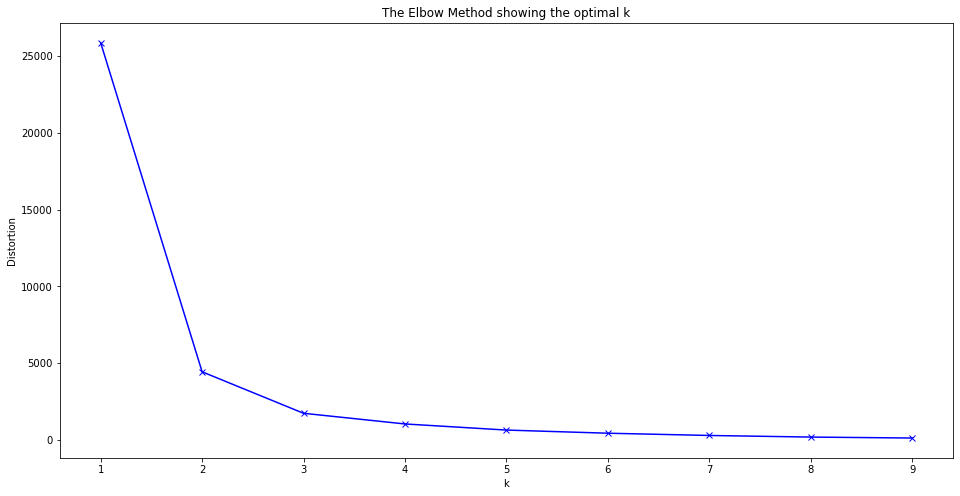

In [33]:
rent_grouped_clustering = dfRent_kmeans[['room', 'studio', 't1', 'High', 'Medium', 'Low', 'Subway station <1km', 'Number venues <500m']]

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(rent_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
# set number of clusters
kclusters = 3


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rent_grouped_clustering)

# add clustering labels
dfRent.insert(0, 'Cluster Labels', kmeans.labels_)

dfRent

,Cluster Labels,Type,Furniture,Bills included,Latitude,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km,Number venues <500m
0,2,room,yes,yes,41.171966,-8.587178,410,High,False,3,17
1,2,room,yes,yes,41.191279,-8.615421,300,Medium,False,0,10
2,2,room,yes,no,41.166586,-8.597017,380,Medium,True,8,13
3,0,room,yes,yes,41.122323,-8.607831,350,Medium,True,4,34
4,0,room,yes,yes,41.152645,-8.621085,380,Medium,False,7,40
5,2,room,yes,no,41.177033,-8.611005,400,Medium,False,3,12
6,2,room,yes,no,41.171456,-8.594277,400,Medium,True,7,5
7,0,room,yes,yes,41.121041,-8.606290,200,Low,True,3,24
8,2,room,yes,no,41.178154,-8.549249,350,Medium,False,0,4
9,2,room,yes,no,41.184385,-8.608058,350,Medium,True,3,16


In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, classe, cluster in zip(dfRent['Latitude'], dfRent['Longitude'], dfRent['Class price'], dfRent['Cluster Labels']):
    label = folium.Popup(str(classe) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 


In [36]:
dfRent.loc[dfRent['Cluster Labels'] == 0, dfRent.columns[[1] + list(range(5, dfRent.shape[1]))]]

,Type,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km,Number venues <500m
3,room,-8.607831,350,Medium,True,4,34
4,room,-8.621085,380,Medium,False,7,40
7,room,-8.606290,200,Low,True,3,24
14,room,-8.603759,285,Low,True,7,36
17,room,-8.603845,415,High,True,7,34
18,room,-8.609370,300,Medium,True,2,24
22,room,-8.611381,600,High,True,9,29
32,studio,-8.621070,620,High,False,5,44


In [37]:
dfRent.loc[dfRent['Cluster Labels'] == 1, dfRent.columns[[1] + list(range(5, dfRent.shape[1]))]]

,Type,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km,Number venues <500m
23,room,-8.617487,600,High,False,5,100
24,t1,-8.608352,1090,High,True,4,70
29,studio,-8.613247,550,High,True,5,88
35,t1,-8.603818,700,High,False,4,97
36,t1,-8.611848,850,High,True,5,83


In [38]:
dfRent.loc[dfRent['Cluster Labels'] == 2, dfRent.columns[[1] + list(range(5, dfRent.shape[1]))]]

,Type,Longitude,Price €/month,Class price,Subway station <1km,Number gyms <1km,Number venues <500m
0,room,-8.587178,410,High,False,3,17
1,room,-8.615421,300,Medium,False,0,10
2,room,-8.597017,380,Medium,True,8,13
5,room,-8.611005,400,Medium,False,3,12
6,room,-8.594277,400,Medium,True,7,5
8,room,-8.549249,350,Medium,False,0,4
9,room,-8.608058,350,Medium,True,3,16
10,room,-8.608470,325,Medium,True,3,22
11,room,-8.603134,275,Low,True,8,16
12,room,-8.638649,360,Medium,True,1,12


## Results and Discussion <a name="results"></a>

The results of processing the dataset were a reducing from 50 to 11 viable places to considerer renting. This reducing of 1/5 was expectable and making this gape the biggest possible (reducing the viable options to help on the choice) was the goal of this project. When we try to answer the question that I made at the beginning "If I get a job offer in a different city, what would be the best places to considerer moving in?" we ended up doing a similar analysis. We check the location, we check the neighborhood review, there is a supermarket close? Can I park my car on a safe parking lot? I used my personal preferences on this work, but I still feel that a lot of more could be considered. But the goal of getting all the places close to a subway station and with a gym close by where fulfilled.   

While applying the k-means algorithm, we can see that the number of venues close by have an influence on the price of the place. This is especially notorious on the second cluster which corresponds to the overall higher prices and the most umber of venues close by. Obtain this information is important. If 2 places have the same price, but one of them has more venues around, this could be that the place with less venues can be overpriced. But more details are required before assuming this but is an interesting information to start by in a future work.


## Conclusion <a name="conclusion"></a>

Overall the goal of my project was fulfilled, I used computational tools to solve my problem using data science steps, with a specially focus on the data analysis and preparation. Solving a Data Science problem doesn’t mean working with Machine Learning or complicated algorithms as we learned through this course. Sometimes the cleaning of the dataset and adding more info can perfectly fulfill your main goal like I did here. I tried to don’t overcomplicated this project because we were supposed to spent around 30 hours on creating a problem to solve, get the dataset and producing a report, notebook and presentation. To increase the quality of this work, as any work in data science, a bigger and more detailed dataset would be a huge improvement. Also, a more detailed analysis of the venues and districts within the city of Porto will certain find interesting conclusion that can help during this filtering process of finding a place to renting.

[1] https://www.google.com/maps  
[2] https://www.idealista.pt/